In [1]:
#load watermark extension
%load_ext watermark
#print watermark for notebook
%watermark

2018-04-17T21:49:13

CPython 2.7.14
IPython 5.4.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [2]:
#https://ipyton.org/ipython-docdex/config/extsions/autoreload.html
%reload_ext autoreload
%autoreload 2

#version information
%reload_ext version_information
%version_information Cython, matplotlib, numpy, pandas,  qutip, seaborn, scipy, sklearn, tqdm, version_information,


Software,Version
Python,2.7.14 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,5.4.1
OS,Darwin 17.3.0 x86_64 i386 64bit
Cython,0.26.1
matplotlib,2.1.0
numpy,1.13.3
pandas,0.20.3
qutip,The 'qutip' distribution was not found and is required by the application
seaborn,0.8.0
scipy,0.19.1


In [3]:
#standard packages
import pandas as pd
import numpy as np
#package for loop load time bar
from tqdm import tqdm
#statistical and machine learning packages
import scipy as sp
from sklearn.preprocessing import OneHotEncoder

#import scoring for machine learning
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score, auc,precision_recall_curve,classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm



#imports for preparing data for sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn. preprocessing import LabelEncoder

# packages for plotting 
import matplotlib.pyplot as plt
import seaborn as sns
#command to have graphs display in notebook
%matplotlib inline

In [4]:
#loading user order information
instacart_file=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/orders.csv')
df_orders=pd.DataFrame(instacart_file,)
df_orders.head(5)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
df_orders.nunique()

order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [6]:
#capture the last order information for each user
g = df_orders.groupby('user_id')
data_p1=g.last()
data_p1['order_from_last']=1

In [7]:
#capture the second to last order information for each user
data_p2=g.nth(-2)
data_p2['order_from_last']=2

In [8]:
#capture the third to last order information for each user
data_p3=g.nth(-3)
data_p3['order_from_last']=3

In [9]:
#capture the fourth to last order information for each user
data_p4=g.nth(-4)
data_p4['order_from_last']=4

In an effort to save computation time, we will work first with a much smaller portion of the data. At the end of the notebook we will attempt to use as much as our system will allow.

## Concern: 
An issue with data wrangling is deciding how to preserve the time component of order history of the customer. I originally sought to segregate the data by breaking it into chunks by order: the test data is the customer's 2nd previous order, the training data the customer’s the 3rd and 4th previous orders together then splitting on it to cross validate. I then test on the 2nd to previous order as the test set. This was taking way to much time to run. I've adjust to a small test run below. The training data is only a small portion 150 cutomer orders from the 3rd previous order they made. The test set is the customers 2nd previous order. ( The most current previous order did not have lavels for all customers, hence, I choose to move to the customers 2nd previous order).

I feel like this should work on a much larger set. This data come from a kaggle competition so I feel like I shouldn't have to reduce as much as I am. Thoughts on how I'm approaching the data set up wrong? Insights in how to reduce run time to maximize data usage? 

# The small set test drive

In [10]:
#capture the third to last order information for each user
data_p3=data_p3.reset_index()

#loading product reorder information
instacart_file2=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/order_products__prior.csv')
df_prod_orders=pd.DataFrame(instacart_file2,)
df_prod_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
#loading information for product names
instacart_products=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/products.csv')
df_prod=pd.DataFrame(instacart_products,)
df_prod.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [12]:
#add reorder information to training data
df_train=pd.merge(df_prod_orders,data_p3, how= 'inner',left_on="order_id", right_on='order_id')
df_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,7,34050,1,0,142903,30.0,prior,2,14,11,3
1,7,46802,2,0,142903,30.0,prior,2,14,11,3
2,16,9755,1,1,174840,13.0,prior,3,12,18,3
3,16,25466,2,0,174840,13.0,prior,3,12,18,3
4,16,45437,3,0,174840,13.0,prior,3,12,18,3


In [13]:
#check to make sure NaN is taken care of 
df_train.isnull().any()

order_id                  False
product_id                False
add_to_cart_order         False
reordered                 False
user_id                   False
days_since_prior_order    False
eval_set                  False
order_dow                 False
order_hour_of_day         False
order_number              False
order_from_last           False
dtype: bool

In [14]:
#see how many products and users we have 
df_train.nunique()

order_id                  206209
product_id                 42505
add_to_cart_order            100
reordered                      2
user_id                   206209
days_since_prior_order        31
eval_set                       1
order_dow                      7
order_hour_of_day             24
order_number                  97
order_from_last                1
dtype: int64

In [15]:
#sample 150 customers to make predictions for 
small_train=df_train.sample(550)
small_train.nunique()

order_id                  547
product_id                480
add_to_cart_order          37
reordered                   2
user_id                   547
days_since_prior_order     31
eval_set                    1
order_dow                   7
order_hour_of_day          23
order_number               66
order_from_last             1
dtype: int64

In [16]:
#data frame to ensure we have the same users in the test set
sample=pd.DataFrame(small_train['user_id'])

#capture the second to last order information for each user as a test set
data_p2=g.nth(-2)
data_p2['order_from_last']=2
data_p2=data_p2.reset_index()

#for test set add in reorder information
df_test=pd.merge(df_prod_orders,data_p2, how= 'inner',left_on="order_id", right_on='order_id')

#since we have train and test data broken apart by user previous order we can ensure we test only the users we trained for
small_test=pd.merge(df_test,sample, how= 'inner',left_on="user_id", right_on='user_id')
small_test.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,1437,23023,1,1,85028,30.0,prior,1,12,33,2
1,1437,459,2,1,85028,30.0,prior,1,12,33,2
2,1437,24852,3,1,85028,30.0,prior,1,12,33,2
3,1437,524,4,1,85028,30.0,prior,1,12,33,2
4,1437,26826,5,1,85028,30.0,prior,1,12,33,2


In [17]:
#small_test=df_test.sample(150)
small_test.nunique()

order_id                   547
product_id                4100
add_to_cart_order           55
reordered                    2
user_id                    547
days_since_prior_order      31
eval_set                     1
order_dow                    7
order_hour_of_day           22
order_number                66
order_from_last              1
dtype: int64

## Now we prep the feature columns to be in an appropriate format to utilize sklearn api 

In [18]:
#use pandas one hot encoder on training data's order_dow with added 'day' to column name
df_dow=pd.get_dummies(small_train['order_dow'],prefix='day')
#add reorder information to training data
train=pd.merge(small_train,df_dow, how= 'inner',left_index= True, right_index=True)
train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last,day_0,day_1,day_2,day_3,day_4,day_5,day_6
1799502,2911474,18168,5,0,126055,11.0,prior,0,13,3,3,1,0,0,0,0,0,0
1819186,2945263,7039,2,1,133008,17.0,prior,5,9,15,3,0,0,0,0,0,1,0
1613118,2608925,31423,26,0,82635,30.0,prior,3,18,4,3,0,0,0,1,0,0,0
1363904,2212616,31040,10,0,38475,6.0,prior,0,16,13,3,1,0,0,0,0,0,0
1020552,1660064,49520,11,0,176812,27.0,prior,6,20,18,3,0,0,0,0,0,0,1


In [19]:
#use pandas one hot encoder on test data's order_dow with added 'day' to column name 
df_dow=pd.get_dummies(small_test['order_dow'],prefix='day')
#add reorder information to training data
test=pd.merge(small_test,df_dow, how= 'inner',left_index= True, right_index=True)
test.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,1437,23023,1,1,85028,30.0,prior,1,12,33,2,0,1,0,0,0,0,0
1,1437,459,2,1,85028,30.0,prior,1,12,33,2,0,1,0,0,0,0,0
2,1437,24852,3,1,85028,30.0,prior,1,12,33,2,0,1,0,0,0,0,0
3,1437,524,4,1,85028,30.0,prior,1,12,33,2,0,1,0,0,0,0,0
4,1437,26826,5,1,85028,30.0,prior,1,12,33,2,0,1,0,0,0,0,0


In [20]:
#capture feature names and make a list
features=train[['add_to_cart_order', 'days_since_prior_order', 'order_dow','order_hour_of_day', 'order_number', 'order_from_last', 'day_0','day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']]
feature_list = list(features.columns)
features=features.columns


#make a training set for sklearn features
xtrain = train[features]

#make a test set for sklearn features
xtest = test[features]

#convert target column into array for training set
ytrain = pd.factorize(small_train['reordered'])[0]

#convert target column into array for test set 
ytest = pd.factorize(small_test['reordered'])[0]


In [21]:
#see if the training data has the proper balance of reorders 
print ('% reorders in training set {:2f}'.format(float(ytrain.sum())/ytrain.size))
print ('% reorders in test set {:2f}'.format(float(ytest.sum())/ytest.size))

% reorders in training set 0.550909
% reorders in test set 0.376079


# Question
Should I be concerned about the difference here in imbalance here? The EDA of all the data showed that reorders occured at 60% overall. Here in the training set, which is all the 3rd previous orders for customers the reorder rate  and the test set are also different. 

# Question:
What is to long for a runtime? This one, the randomized grid search, takes a few hours in the full set I would like to run.


## Now we use svm with rbf kernel on the data to make predictions for reorders

In [22]:
#to tune parameters 
clf=svm.SVC(kernel='rbf')

#fit classifier to validation set
clf.fit( xtrain , ytrain )

#get the prediction set for the validation 
preds_train_svm = clf.predict( xtrain )

#make some predictions
preds_svm = clf.predict( xtest )


#print the accuracy score for the training data
training_accuracy = clf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_svm )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_svm , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )

print (classification_report( ytest , preds_svm ))

Accuracy on training data: 0.95
Accuracy on test data: 0.36
F1 Score on train data: 0.9588
F1 Score on validation (train-test set) data: 0.4422
             precision    recall  f1-score   support

          0       0.47      0.18      0.26      5060
          1       0.33      0.67      0.44      3050

avg / total       0.42      0.36      0.33      8110



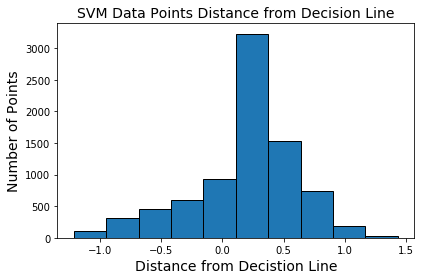

In [23]:
#can look at decision line 
clf.decision_function(xtest)

#plot the histogram of distance from boundry
plt.hist(clf.decision_function(xtest),edgecolor='k')
#add labels and title
plt.xlabel("Distance from Decistion Line", {'fontsize': 14})
plt.ylabel("Number of Points", {'fontsize': 14})

plt.title("SVM Data Points Distance from Decision Line", {'fontsize': 14})
#save figure for papers
plt.tight_layout()
plt.savefig('svm_distance.png')
#show figure in notebook
plt.show()

   classification report, which lists recovery statistics label by label
   
   # I should tune parametes here. Definitely overfitting
   
   SVM does not have predict_proba module. We can instead plot the distance from the decision line.
   Can plot a histogram od the decision function. Need to work on making plot of the decision function on the plane. 
   See if I can plot the support vectors as well.


In [24]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [25]:
#look at confusion matrix
confusion_matrix( ytest , preds_svm )

array([[ 910, 4150],
       [1006, 2044]])

## Now look at model measurements: ROC Curve, Precision-Recall Curves and AUC 

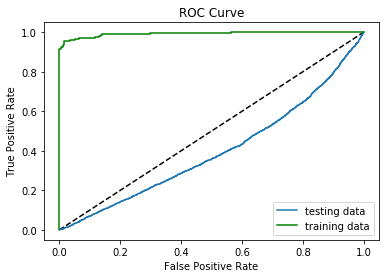

In [26]:
#predict the probabilities for each observation in training set
#pred_train_prob_svm = clf.decision_function(xtrain)[:,1]

#predict the probabilities for each observation in test set
#pred_prob_svm = clf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr , xtpr , xthres = roc_curve(ytrain , clf.decision_function(xtrain) )

#get false positive rate, true positive rate, and thresholds for test data
fpr , tpr , thres = roc_curve( ytest , clf.decision_function(xtest))

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot(fpr,tpr,label='testing data')
plt.plot(xfpr,xtpr, 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

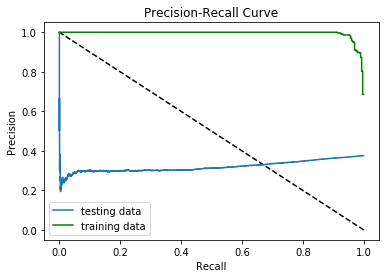

In [27]:
xprec_score,xrecall_score,xthresholds=precision_recall_curve( ytrain , clf.decision_function(xtrain) )

prec_score,recall_score,thresholds=precision_recall_curve( ytest , clf.decision_function(xtest))

plt.plot([1,0],[0,1],'k--')
plt.plot(recall_score,prec_score,label='testing data')
plt.plot(xrecall_score,xprec_score,'g-',label='training data')
#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [28]:
roc_auc_score(ytest , clf.decision_function(xtest))

0.39680758763688195

In [29]:
cv_auc_scores=cross_val_score(clf, xtrain , ytrain, cv=5, scoring='roc_auc')
print(cv_auc_scores)

[ 0.64262295  0.7042623   0.64603546  0.65204082  0.63095238]


## The above was with default settings lets tune the model and see if we can imporve.

In [30]:
#know lets tune the parameters for the svm 
from sklearn.model_selection import StratifiedShuffleSplit

# Sklearn recommends for an initial search, a logarithmic grid with basis 10 is often helpful. Using a basis 
# of 2, a finer tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
#param_grid = dict(gamma=gamma_range, C=C_range)

parameters = {'C': C_range , 'gamma' : gamma_range }
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
            

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(clf,  param_distributions= parameters ,cv= cv, refit= True, n_jobs= 2, random_state= 42, scoring='f1')

#fit grid search on random forest over grid
%time rs.fit( xtrain ,  ytrain )

CPU times: user 301 ms, sys: 80.3 ms, total: 381 ms
Wall time: 3min 32s


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03])},
          pre_dispatch='2*n_jobs', random_state=42

# Question:
Does my approach at cross-validation voilate any principles? Do you see anything wrong here? Can I do it better?

In [31]:
#save best parameters to use on test set
best_c = rs.best_params_['C'] 
best_gamma=rs.best_params_['gamma'] 

#print best parameter results
print("the best regulization C is {} and the best gamma, radius of influence of support vectors is {}".format(best_c,best_gamma))
print("the best f1 score with these is {}".format(rs.best_score_))

the best regulization C is 10000000000.0 and the best gamma, radius of influence of support vectors is 1.0
the best f1 score with these is 0.715968352253


In [32]:
#to tune parameters 
clf_svm=svm.SVC( kernel='rbf', C= best_c , gamma= best_gamma )

#fit classifier to validation set
clf_svm.fit( xtrain , ytrain )

#get the prediction set for the validation 
preds_train_svm = clf_svm.predict( xtrain )

#make some predictions
preds_svm = clf_svm.predict( xtest )


#print the accuracy score for the training data
training_accuracy = clf_svm.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_svm.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_svm )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_svm , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )

print (classification_report( ytest , preds_svm ))

Accuracy on training data: 1.00
Accuracy on test data: 0.38
F1 Score on train data: 1.0000
F1 Score on validation (train-test set) data: 0.5442
             precision    recall  f1-score   support

          0       0.40      0.00      0.01      5060
          1       0.37      0.99      0.54      3050

avg / total       0.39      0.38      0.21      8110



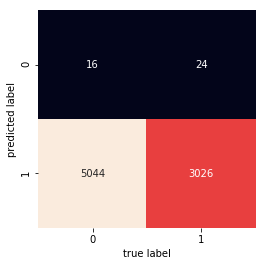

In [33]:

mat = confusion_matrix( ytest , preds_svm  )
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

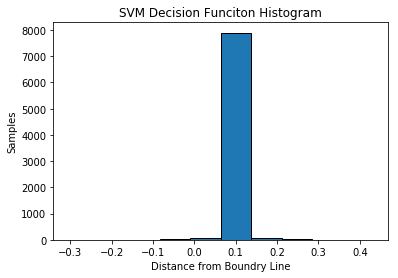

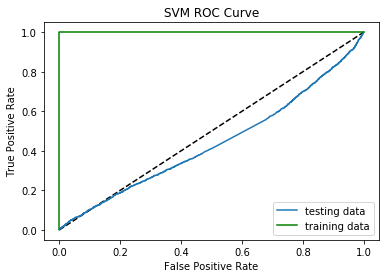

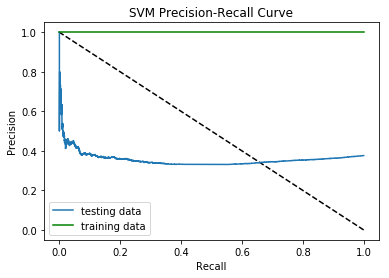

The Area Under the Curve foe the Support Vector Machine is 0.44


In [34]:
#can look at decision line 
clf_svm.decision_function(xtest)

#plot the histogram of distance from boundry
plt.hist(clf_svm.decision_function(xtest),edgecolor='k' )
#add labels
plt.xlabel("Distance from Boundry Line")
plt.ylabel("Samples")
plt.title('SVM Decision Funciton Histogram')
plt.legend(loc=3)
plt.show()


#plot ROC curve 
#get false positive rate, true positive rate, and thresholds for training data
xfpr_svm , xtpr_svm , xthres_svm = roc_curve(ytrain , clf_svm.decision_function(xtrain) )

#get false positive rate, true positive rate, and thresholds for test data
fpr_svm , tpr_svm , thres_svm = roc_curve( ytest , clf_svm.decision_function(xtest) )

#plot base line at .5 probability
plt.plot( [0,1] , [0,1] , 'k--' )
#plot model train and test
plt.plot( fpr_svm , tpr_svm , label= 'testing data')
plt.plot( xfpr_svm , xtpr_svm , 'g-', label= 'training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('SVM ROC Curve')
plt.legend(loc=4)
plt.show()

#plot the precision-recall curve for tuned model
#get values for training set
xprec_score_svm , xrecall_score_svm ,xthresholds_svm =precision_recall_curve( ytrain , clf_svm.decision_function(xtrain) )
#get values for test set
prec_score_svm , recall_score_svm , thresholds_svm = precision_recall_curve( ytest , clf_svm.decision_function(xtest))

#plot lines
plt.plot( [1,0] , [0,1] , 'k--' )
plt.plot( recall_score_svm , prec_score_svm , label= 'testing data')
plt.plot( xrecall_score_svm , xprec_score_svm , 'g-' , label= 'training data')
#add labels
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('SVM Precision-Recall Curve')
plt.legend(loc=3)
plt.show()
         
svm_test_auc=roc_auc_score(ytest , clf_svm.decision_function(xtest))  
print("The Area Under the Curve foe the Support Vector Machine is {:.2f}".format(svm_test_auc))

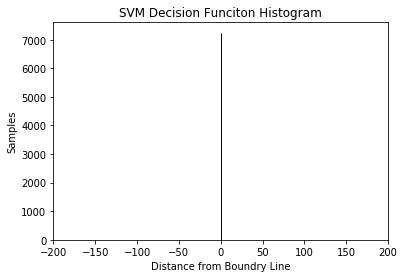

In [35]:
#plot the histogram of distance from boundry
plt.hist(clf_svm.decision_function(xtest),bins='sqrt',edgecolor='k' )
plt.xlim(-200,200)
#add labels
plt.xlabel("Distance from Boundry Line")
plt.ylabel("Samples")
plt.title('SVM Decision Funciton Histogram')
plt.legend(loc=3)
plt.show()



In [36]:
plot_svc_decision_function(clf_svm)

NameError: name 'plot_svc_decision_function' is not defined

In [ ]:
plt.scatter(clf_svm.support_, clf_svm.dual_coef_[0,:]);

In [ ]:
clf_svm.support_.shape

In [ ]:
clf_svm.n_support_.shape

In [ ]:
clf_svm.intercept_

In [ ]:
clf_svm.decision_function(xtest).shape

In [ ]:
clf_svm.dual_coef_[0,:].shape

We see, looking closer at the histogram, the distance each point lays from the separator. Most points are near the boundry indictating that reorders and non-reorders look very similiar. This is an indication that we might need to look for more features to differentiate the classes. In an apple an orange example, we could be only looking at the roundness of the fruit instead of the color. We would hope to find some feature that separates the classes a bit better than this.  

## Improvements to make later: add one hot encode to hod column, scale/normalize all features, cross validate the auc scores, plot decision boundry on plane, add feature engineering...

# Next Random Forest 
the mini version

In [ ]:
#know lets tune the parameters for the random forest

#set parametets to tune in Random Grid Search (# trees in forest and # of features per tree)
parameters={'n_estimators':range(20,40),'max_features':['auto',1,2,3,4,5]}

#create an instance of the random forest classifier
rf=RandomForestClassifier()

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(rf, param_distributions=parameters,cv=5,refit=True,n_jobs=2,random_state=42,scoring='f1')

#fit grid search on random forest over grid
rs.fit( xtrain ,  ytrain )

## Question
How do you pick the appropriate range for # of trees? The best # of trees was at the top range of trees. I’m thinking the model will always want the top number (its overfitting).  Should I also tune the gini purity or the minimum leaf node parameter? What all do you recommend to tune in the random forest? 

Model is overfitting on training data (.86 compared to .61). Could look at tuning the gini-index (or leaf node min).


In [ ]:
#save best parameters to use on test set
best_n = rs.best_params_['n_estimators'] 
best_features=rs.best_params_['max_features'] 

#print best parameter results
print("the best number of trees is {} with a maximum number of features of {}".format(best_n,best_features))
print("the best f1 score with these is {}".format(rs.best_score_))

In [ ]:
#create classifier from best parameters out of grid search
clf_rf=rs.best_estimator_
#fit classifier to validation set
clf_rf.fit(xtrain,ytrain)

#get the prediction set for the validation 
preds_train_rf = clf_rf.predict(xtrain)

#make some predictions
preds_rf = clf_rf.predict(xtest)


#print the accuracy score for the training data
training_accuracy = clf_rf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_rf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )


print ( classification_report ( ytest , preds_rf ))

In [ ]:
#look at confusion matrix
confusion_matrix( ytest , preds_rf )

In [ ]:
#Capture model feature importance 
importances=clf_rf.feature_importances_

In [ ]:
#plot the variable importances
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Random Forest Variable Importances');

#save figure
plt.savefig('feature_importance.png')
#show figure in notebook
plt.show()

In [ ]:
#predict the probabilities for each observation in training set
pred_train_prob_rf = clf_rf.predict_proba(xtrain)[:,1]

#predict the probabilities for each observation in test set
pred_prob_rf = clf_rf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr_rf , xtpr_rf , xthres_rf = roc_curve(ytrain , pred_train_prob_rf )

#get false positive rate, true positive rate, and thresholds for test data
fpr_rf , tpr_rf , thres_rf = roc_curve( ytest , pred_prob_rf )

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot( fpr_rf , tpr_rf ,label='testing data')
plt.plot( xfpr_rf , xtpr_rf , 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC Curve')
plt.legend(loc=4)
plt.show()

In [ ]:

xprec_score_rf , xrecall_score_rf ,xthresholds_rf = precision_recall_curve( ytrain , pred_train_prob_rf )

prec_score_rf , recall_score_rf ,thresholds_rf = precision_recall_curve( ytest , pred_prob_rf)

plt.plot([1,0],[0,1],'k--')
plt.plot( recall_score_rf , prec_score_rf ,label='testing data')
plt.plot( xrecall_score_rf , xprec_score_rf ,'g-',label='training data')

#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Random Forest Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [ ]:
rf_test_auc=roc_auc_score(ytest , pred_prob_rf)
print("The Area Under the Curve foe the Randam Forest is {:.2f}".format(rf_test_auc))

In [ ]:
# cross validate on scoring of auc (20 min to run) 
cv_auc_scores=cross_val_score(clf, xtrain , ytrain , cv=5, scoring='roc_auc')
print(cv_auc_scores)

In [ ]:
#Plot both models together

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test for each model
plt.plot(xfpr_rf , xtpr_rf , c='chocolate', label='Training RF Data')
plt.plot(fpr_rf , tpr_rf , c='sandybrown', label='Testing RF Data')
plt.plot(xfpr_svm , xtpr_svm , c='yellowgreen' , label='Training SVM Data')
plt.plot(fpr_svm , tpr_svm ,c='lightgreen' , label='Testing SVM Data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(' ROC Curve')
plt.legend(loc=4)
#save figure for papers
plt.tight_layout()
plt.savefig('models_roc.png')
#show figure in notebook
plt.show()

#plot both Precision_Recall models on one
plt.plot([1,0],[0,1],'k--')
plt.plot(xrecall_score_rf , xprec_score_rf, c='chocolate',label='Training RF Data')
plt.plot(recall_score_rf , prec_score_rf,  c='sandybrown' ,label='Testing RF Data')

plt.plot( xrecall_score_svm , xprec_score_svm , c='yellowgreen' , label= 'Training SVM Data')
plt.plot( recall_score_svm , prec_score_svm , c='lightgreen', label= 'Testing SVM Data')

#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(' Precision-Recall Curve')
plt.legend(loc=4)
#save figure for papers
plt.tight_layout()
plt.savefig('models_PR-curve.png')
#show figure in notebook
plt.show()

In [ ]:
#dictionary to hold auc scores form tuned models
plot_model={'RF':rf_test_auc ,'SVM':svm_test_auc}

#make an instance for plotting figures
fig, ax = plt.subplots()

#set parameters for bar chart
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

#plot bar for chart
rects1 = ax.bar(ind, plot_model.values(), color= ['sandybrown','lightgreen'])

#define a function to add bar chart labels to bars (straight from matplotlib docs)
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*float(height),'%.3f' % float(height),ha='center', va='bottom')
        
#call function to add bar char labels to bars
autolabel(rects1)


# add some text for axes ticks
ax.set_xticks(ind)
ax.set_xticklabels(plot_model.keys())

ax.legend()

#add label and title
plt.title("Comparison of the different models",y = 1.08)
plt.xlabel("Models")
plt.ylabel("AUC Score on Test Set")
#save figure for papers
plt.tight_layout()
plt.savefig('models_auc.png')
#show figure in notebook
plt.show()


In [ ]:
clf_svm.decision_function ( np.c_[xx.ravel() , yy.ravel() ] )

In [ ]:
plt.figure()
#ax.plt.gca()

#xmin, xmax = xtrain.min() - .5, xtrain.size +.05
ymin, ymax = ytrain.min() - .5, ytrain.size +.05
xx, yy =np.meshgrid ( np.linspace(ymin , ymax, 100), np.linspace(ymin , ymax, 100) )

z= clf_svm.predict ( np.c_[xx.ravel() , yy.ravel() ] )
z= z.reshape( xx.shape )

In [ ]:
xtrain[0:1]

In [ ]:
# draw visualization of parameter effects
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
x = scaler.fit_transform(xtrain)
#y = scaler.fit_transform(ytrain)

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-13, 13, 200), np.linspace(-13, 13, 200))
#for k, C, gamma in clf_svm:
    # evaluate decision function in a grid
Z = clf_svm.decision_function(x , ytrain[:,0])
Z = Z.reshape(xx.shape)



# Concern:
The Kaggle competition best f1 score was around .409. I have my output slightly different. How can I be doing so much better with such little feature engineering? I feel like I must be doing something wrong here. 

In [ ]:
plot_model={'RF':rf_test_auc ,'SVM':svm_test_auc}

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='r', yerr=men_std)

plt.bar(plot_model.keys(), plot_model.values(), color= ['sandybrown','lightgreen'])


#add label and title
plt.title("Comparison of the different models")
plt.xlabel("Models")
plt.ylabel("AUC Score on Test Set")
#save figure for papers
plt.tight_layout()
plt.savefig('models_auc.png')
#show figure in notebook
plt.show()

